<h1 align = 'center'> <b>Compreendo os Mecanismos de Processamento 
de Imagem no Gwyddion por Operações de Matrizes Em Python <b></h1>

<h5>Desenvolvedores: José David A. Sales, Diogo P. Carvalho, Natália A. de Souza e Kayllany S. Oliveira</h5>

Inicialmente, as bibliotecas PIL, numpy e matplotlib são importadas para, respectivamente, permitir que a imagem em png seja carregada, converter a imagem para matriz e realizar operações com arrays e plotar as matrizes como imagens. 

In [13]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


A célula abaixo realiza o carregamento da imagem a ser trabalhada. Você pode adicionar nessa mesma pasta uma outra imagem de AFM ou STM, caso queira, para poder acompanhar os processos de tratamento 

In [14]:
imagem = Image.open('grafite.png') #A imagem é aberta com o módulo Image importada da biblioteca PIL(pode-se mudar 'grafite.png' para 'CD.png', ou para qualquer outra imagem que prefeir)
imagem = imagem.convert('L')  #Converte a imagem de matriz de vetores rgb para uma escala de cinza 
imagem = np.array(imagem)    #Imagem como sendo um array numpy


É possível visualizar a matriz que compõe a imagem usando o comando print para exibir o array, e verificar o número de linhas e colunas por meio da função shape.

In [15]:
print(imagem)
print(f'\n A matriz que compõe a imagem possui {imagem.shape[0]} linhas e {imagem.shape[1]} colunas')

[[233 233 233 ... 212 213 213]
 [233 233 233 ... 212 213 213]
 [232 232 232 ... 211 211 211]
 ...
 [ 43  43  43 ...  21  21  21]
 [ 43  43  42 ...  20  20  20]
 [ 43  43  42 ...  20  20  20]]

 A matriz que compõe a imagem possui 500 linhas e 500 colunas


Atráves da função imshow da biblioteca matplotlib é possível plotar a matriz como uma imagem. Como esta não possui vetores RGB ainda, é preciso usar o argumento cmap na função para adicionar algum gradiente na representação. Nesse caso, o gradiente usado foi uma escala de cinza.

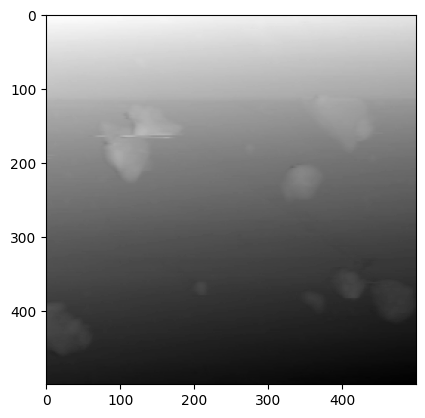

In [16]:
plt.imshow(imagem, cmap='gray')

A primeira ferramenta do <i>Gwyddion</i>  a ser explorada é o Plane Level, que permite a planagem da imagem. A função abaixa replica o funcionamento desta. O processo de planagem consiste subtrair a matriz orignal por uma matriz plano de fundo. Essa matriz plano de fundo é composto por uma função z(i,j).<br>

$$
\text{Plano de fundo} = 
\begin{bmatrix}
    z(0,0) & \cdots & z(0,j) \\
    \vdots & \ddots & \vdots \\
    z(i,0) & z(i,1) & z(i,j)
\end{bmatrix}
$$
 $$ z(i,j) = i \cdot a + j \cdot b + c $$
<p align = 'justify'>Os argumento i e j que a função z recebe são a coordenadas de linha e coluna da matriz. Os coeficientes a, b 
e c são encontrados atráves de uma regressão linear por meio da função lstsq(Least Squares), a qual calcula esses coeficientes por meio do método dos mínimos quadrados. Dessa maneira, a função z é feita como uma tentativa de tentar definir a imagem como uma função matemática. Essa tentativa é falha, pois a imagem possui várias irregularidades em seu meio, porém a função é capaz de gerar uma função que replica o gradiente da imagem. O gradiente replicado que forma a matriz plano de fundo, que quando subtraido da matriz original, permite que cheguemos na imagem retificada. <p>

In [17]:
def desentortar(imagem_qualquer):
    '''
    A função desentortar recebe uma matriz qualquer como argumento. A partir de uma regressão linear,
    usando o método dos mínimos quadrados, o código encontra os coeficientes da função z(i,j) que
    melhor descreve a imagem. Usando essa função, pode-se chegar em uma matriz plano de fundo, a qual
    ao ser substrada da imagem qualquer, permite a nivelação da imagem. 
    
    '''
    
    x, y = np.meshgrid(np.arange(imagem_qualquer.shape[1]), np.arange(imagem_qualquer.shape[0]))
    A = np.vstack((y.ravel(),x.ravel(), np.ones(x.size))).T
    B = imagem_qualquer.ravel()
    fit = np.linalg.lstsq(A, B, rcond=None)[0]
    plano_de_fundo = fit[0] * y + fit[1] * x + fit[2]

    imagem_nivelada = imagem_qualquer - plano_de_fundo
    
    return imagem_nivelada, plano_de_fundo

Na célula abaixo, o uso do imshow é feito em subplots para exibir o a imagem original, o plano de fundo e a imagem retificadas em um único output.

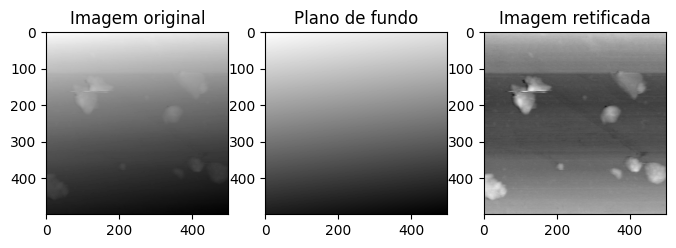

In [18]:
desentortada, fundo = desentortar(imagem)

fig, axs = plt.subplots(1, 3, figsize=(8, 4))

axs[0].imshow(imagem, cmap= 'gray')
axs[0].set_title('Imagem original') 

axs[1].imshow(fundo, cmap= 'gray')
axs[1].set_title('Plano de fundo')


axs[2].imshow(desentortada, cmap= 'gray')
axs[2].set_title('Imagem retificada')


plt.show()

A função criada na célula abaixa realiza o filtro por mediana em uma matriz qualquer submetida na função. O filtro de mediana função por meio da subtração da matriz original por sua matriz de mediana horizontais, a qual pode ser intitulada como plano de mediana. 
<br>
$$
\text{Plano de medianas} = 
\begin{bmatrix}
    Med(matriz(0))_{0,0} & \cdots & Med(matriz(0))_{0,j} \\
    \vdots & \ddots & \vdots \\
    Med(matriz(i))_{i,0} & Med(matriz(i))_{i,1} & Med(matriz(i))_{i,j}
\end{bmatrix}
$$

<p align = 'justify'>A função filtro_mediana funciona através da criação de uma matriz repleta de zeros. Dois loops for são feitos para preencher essa matriz com as medianas. Para cada linha, o cálculo da mediana da linha é feito e para cada coluna nas linhas, o item na mesma linha de onde a mediana foi cálcula é igual a mediana.<p>

In [19]:
def filtro_mediana(imagem_qualquer):
    
    '''
    A função filtro_mediana recebe uma matriz qualquer como argumento. A partir do cálculo da mediana
    de cada linha, uma nova matriz com as mediana das linhas é criada e subtraída da matriz_qualquer.
    Ao fim, a função retornar tanta a imagem filtrada, quanto o plano de medianas.
    
    '''
    
    
    n_linhas, n_colunas = imagem_qualquer.shape
    plano_de_medianas = np.zeros((n_linhas,n_colunas))
    for i in range(n_linhas):
        mediana = np.median(imagem_qualquer[i])
        for j in range(n_colunas):
            plano_de_medianas[i][j] = mediana 

    imagem_filtrada = imagem_qualquer - plano_de_medianas
    
    return imagem_filtrada,plano_de_medianas

Na célula abaixo, o uso do imshow é feito em subplots para exibir o a imagem já retificada, o plano de medianas e a imagem filtrada em um único output.

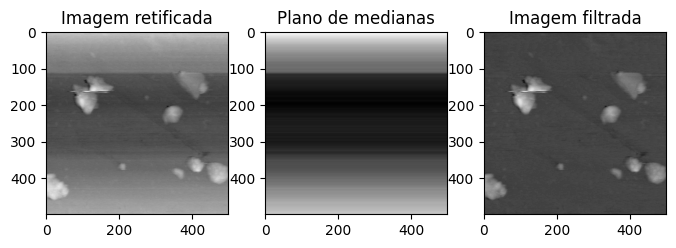

In [20]:
filtrada, fundomediana = filtro_mediana(desentortada)
fig, axs = plt.subplots(1, 3, figsize=(8, 4))

# Exibe a primeira imagem na primeira subtrama.
axs[0].imshow(desentortada, cmap= 'gray')
axs[0].set_title('Imagem retificada')

# Exibe a segunda imagem na segunda subtrama.
axs[1].imshow(fundomediana, cmap= 'gray')
axs[1].set_title('Plano de medianas')

axs[2].imshow(filtrada, cmap= 'gray')
axs[2].set_title('Imagem filtrada')

plt.show()

<p align = 'justify'>Antes de aplicar a cor na imagem, é necessário normalizar os valores, pois as operações realizadas anteriormente não mantém os valores em um intervalo de 0 até 255. O processo de normalização consiste em substrair cada elemento da matrix pelo antigo valor mínimo presente nesta, multiplicar o obtido pela substração do novo valor máximo pela novo valor mínimo(variação), dividir isso pela substração do máximo antigo pelo mínimo antigo e, ao fim, somar isso com o novo valor mínimo. </p>

In [21]:
def normalizar(matriz_qualquer):
    max_antigo = matriz_qualquer.max()
    min_antigo = matriz_qualquer.min()
    max_novo = 255
    min_novo = 0
    
    matriz_normalizada = (matriz_qualquer - min_antigo) * (max_novo - min_novo) / (max_antigo - min_antigo) + min_novo
    return matriz_normalizada

Na célula abaixo, a imagem filtrada_normal é definida como a imagem filtrada submetida à função de normalização

In [22]:
filtrada_normal = normalizar(filtrada)

<p align = 'justify'>Ao fim, a função colorindo é feita para aplicar a cor na imagem. De forma resumida, essa função recebe dois argumentos: uma matriz imagem_cinza e uma matriz_cor. Inicialmente, um condicional é feito para que caso a matriz cor tenha um número de componentes diferente de três, uma imagem de erro seja exibida. Em seguida, as número de linhas e colunas são definidas como o retornado da função shape aplicada na matrziz cinza. Uma matriz colorida inicial é feita como sendo um matriz varia com o mesmo formato da matriz cinza, mas com uma profundidade de 3, ou seja, sendo esta uma matriz de mesmo tamanho mas com um vetor de 3 itens no lugar de cada item da original. Usando o número de linhas e colunas, um loop for é feito para que cada item da matriz colorida seja igual ao produto de cada item da matriz cinza pelo vetor RGB. Ou seja, para aplicação de cor, o processo abaixo acontece:</p>

$$ 
\text{Matriz colorida}= 
\begin{bmatrix}
    a_{11}\cdot \vec{V}_{RGB} & \cdots & a_{1n}\cdot \vec{V}_{RGB}  \\
    \vdots & \ddots & a_{2n}\cdot \vec{V}_{RGB}  \\
    a_{m1}\cdot \vec{V}_{RGB}  & a_{m2}\cdot \vec{V}_{RGB}  & a_{mn}\cdot \vec{V}_{RGB} 
\end{bmatrix}
$$

In [23]:
def colorindo(imagem_cinza, matriz_cor):
    
    '''
    A função colorindo recebe dois argumentos: a imagenm_cinza e a matriz_cor. Nessa função, cria-se uma 
    matriz de mesmo formato da matriz cinza, mas com um vetor de três itens, o qual permite que cada 
    item da matriz cópia possa ser definido como igual ao produto de cada item da matriz em cinza com
    o vetor RGB recebido(matriz cor).
    
    '''
    
    if matriz_cor.shape[0] != 3:
        return('Falha')
    
    cor_normalizada = matriz_cor/matriz_cor.max()
    
    
    linhas, colunas = imagem_cinza.shape
    matriz_colorida = np.empty((linhas, colunas, 3), dtype=int) 

    for i in range(linhas):
        for j in range(colunas):
            matriz_colorida[i, j] = imagem_cinza[i, j] * cor_normalizada
            
    
    
    return matriz_colorida



<p align = 'justify'>A última célula faz a exibição da imagem filtrada sem cor e dessa mesma após ter a cor adicionada. É interessante ressaltar que a função imshow não recebeu o argumento cmap para exibir a imagem colorido, pois, ao receber uma matriz de matrize RBG, a cor do pixel é interpretada sem que seja necessário adiconar um gradiente de cor.</p>

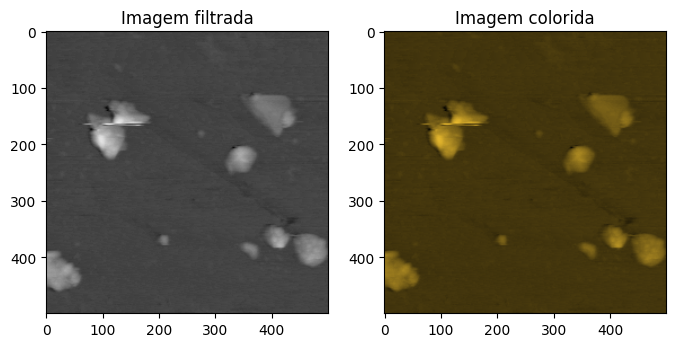

In [24]:
final = filtrada_normal
cor = np.array([150,120,30])
colorida = colorindo(final, cor)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# Exibe a primeira imagem na primeira subtrama.
axs[0].imshow(final, cmap= 'gray')
axs[0].set_title('Imagem filtrada')

# Exibe a segunda imagem na segunda subtrama.
axs[1].imshow(colorida)
axs[1].set_title('Imagem colorida')

plt.show()

<h2>              <b>Referências:</b>   </h2>

1. Bruker. What is an SPM?. Year of Access 2023. Disponível em:
https://www.bruker.com/en/products-and-solutions/microscopes/materials-afm/what-is-
an-spm.html
2. CORRÊA, J. et al. MICROSCOPIA CONFOCAL BÁSICA. Universidade de Brasília Micro-
scopia Confocal Básica. 2012.
3. GitHub José David. Reposit ́orio: do gwyddion ao python. GitHub. Disponível em:
https://github.com/joseDavid23038/do_gwyddio_ao_python.git
4. HE, Kaiming; SUN, Jian; TANG, Xiaoou. Guided image filtering. IEEE Transactions on
Pattern Analysis and Machine Intelligence, v. 35, n. 6, p. 1397-1409, 2012.
5. KLAPETEK, Petr; NECAS, David; ANDERSON, Christopher. Gwyddion user guide. Czech
Metrology Institute, v. 2007, p. 2009, 2004.
6. NAG, H. Applications of Linear Algebra in Image Filters [Part I] - Operations, 2020.
